## Introduction

Multiple myeloma (MM) is a type of blood cancer that affects the plasma cells. In multiple myeloma, malignant plasma cells accumulate in the bone marrow, crowding out the normal plasma cells that help fight infections. These malignant plasma cells then produce abnormal proteins (m protein) which damage the kidneys and interfere with biological processes throughout the body. The malignant plasma cells also increase bone turnover, leaving bones weakened and releasing toxic levels of calcium into the bloodstream. 

<img src='https://www.cdc.gov/cancer/myeloma/images/multiple_myeloma_diagram_english.jpg' width=550>

MM remains a challenging cancer to treat, particularly for a subset of patients with aggressive disease. Despite advances in our understanding of the molecular biology of the disease, identifying patients at high risk of rapid progression remains difficult. Between 15%-25% of multiple myeloma patients will progress (or die) within 18 months of diagnosis regardless of treatment. While risk-adapted therapy is becoming incorporated into treatment protocols, such patients are difficult to confidently identify prior to progression. Therefore, a precise risk stratification model is critical to assist in therapeutic decision-making. 

In collaboration with Myeloma Genome Project (MGP), clinical variables, patient outcomes, genetic, and gene expression data from thousands of samples from private and public studies have been curated and harmonized for this challenge. 

###### Right-censored data (survival problems)

Censoring is a type of missing data problem common in survival analysis. 
The table below represents a typical right-censored data. The first column is the patiet ID, the second column is the last date that the patinet is seen. The thrid column is the status of the patient at last-seen. 1 represents the patient dies at that date, and 0 represents the patient is alive at the last-seen day. Right censoring occurs when a patient leaves the study before an event occurs (loss to follow-up ) or the study ends before the event has occurred, in this case, not all patients are dead at the lat-seen day.  

| Patient ID| Time (day) | Status |
|-----------|------------|--------|
|   10253   |    185     |   0    |
|   102688  |    257     |   1    |
|   101445  |    298     |   1    |
|   10172   |    430     |   0    |
|   101154  |    506     |   1    |


Traditionally, statistical approaches have been widely developed in the literature
to overcome this censoring issue such as Cox model, Kaplan-Meier method and Propotional Hazards model. Most of the statistical methods focus more on both the distributions of the event times and the statistical properties of the parameter estimation. Although compared to traiditional statistical methods, machien learning is effective when there are a large number instances in a reseasonal dimensional feature space, the main drawback of machine learning methods is the difficulty to appropriatedly deal with censored information and the time estimation of the model. 


###### Taxonomy of the methods developed for survival analysis 
[ (from 'Machine Learning for Survival Analysis: A Survey')](http://dmkd.cs.vt.edu/papers/CSUR17.pdf)
<img src='./survival_analysis.png' >

In [57]:
# Import packages
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import venn
from sklearn.datasets import make_classification
from IPython.display import display, Math, Latex
from IPython.display import Image
from IPython.core.display import HTML 
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA


%matplotlib inline

# Classifier
import xgboost as xgb

##### Clinical Data

All the training patient samples are described in the file 'globalClinTraining.csv'. A brief description of the clinical annotation is in the file 'Core_Components_Clinical_Distionary.csv'. 

Each training set has the patient age, sex, ISS stage, overall survival, survival time, progression event indicator and time to progression. 

In [5]:
# loading clinical data
dictionary=pd.read_csv('datasets/clinical_data/Core_Components_Clinical_Dictionary.csv')
globalClin_df=pd.read_csv('datasets/clinical_data/globalClinTraining.csv')
# Description of Clinical data annotation
dictionary.iloc[[0,1,2,3,4,5,6,7,8,9,43],[0,7]]

,names,description
0,Patient,Normalized patient identification number.
1,Study,Study cohort this patient belongs to
2,D_Gender,Gender string
3,D_Age,Age at diagnosis
4,PatientType,Simplified disease presentation status at samp...
5,D_ISS,ISS Disease Stage
6,D_OS,Overall Survival time: time to death for those...
7,D_OS_FLAG,Is the patient deceased? It turns out \death d...
8,D_PFS,Time to PFS (progression-free survival). Study...
9,D_PFS_FLAG,Has the patient developed progressive disease ...


##### Note:
D_OS: Overall Survival time: time to death or time to last contact for those still alive 

D_OS_FLAG: Death event indicator (0='Alive'; 1='Deceased')

D_PFS: Time to disease progression for those who progressed ot time to last contact for those who still have not progressed

D_PFS_FLAG:Progression event indicator (0='No Progression'; 1='Progression')

###### HR_FLAG: High Risk indicator 
It is computed by 'D_PFS' and 'D_PFS_FLAG':
if (D_PFS < 18*30.5 & D_PFS_FLAG == 1) $\rightarrow$ (HR_FLAG = 'TRUE')
  

In [6]:
### Convert days into months
globalClin_df['D_PFS']=globalClin_df['D_PFS']/30.5
globalClin_df['D_OS']=globalClin_df['D_OS']/30.5

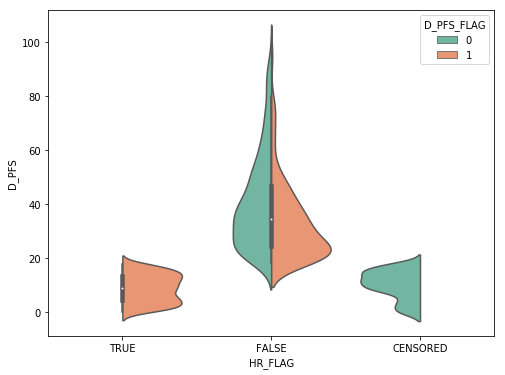

In [7]:
f,ax=plt.subplots(figsize=(8,6))
sns.violinplot("HR_FLAG","D_PFS", hue="D_PFS_FLAG", data=globalClin_df,split=True, palette="Set2")
plt.show()

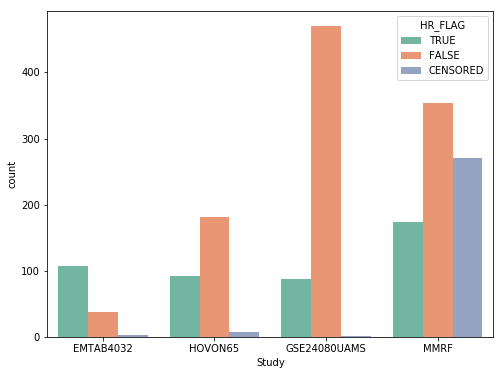

In [8]:
f,ax=plt.subplots(figsize=(8,6))
sns.countplot("Study",hue="HR_FLAG", data=globalClin_df,palette="Set2")
plt.show()


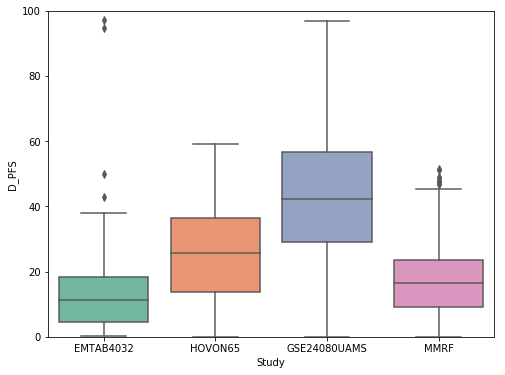

In [73]:
### boxplot shows the distributions of 'D_OS' and 'D_PFS' in four studies
f, ax = plt.subplots(figsize=(8, 6))
var = 'Study'
data = pd.concat([globalClin_df['D_PFS'], globalClin_df[var]], axis=1)
fig = sns.boxplot(x=var, y="D_PFS", data=data,palette="Set2")
fig.axis(ymin=0, ymax=100);

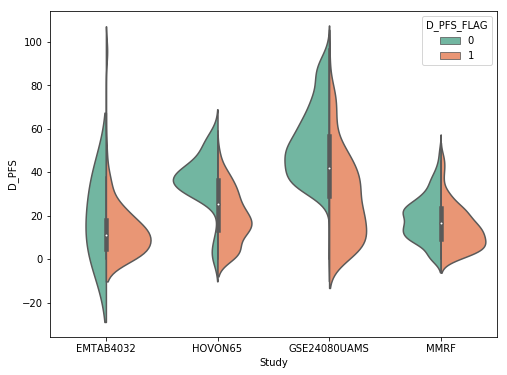

In [10]:
# let's add 'D_OS_FLAG' and 'D_PFS_FLAG' 
f,ax=plt.subplots(figsize=(8,6))
sns.violinplot("Study","D_PFS", hue="D_PFS_FLAG", data=globalClin_df,split=True,palette="Set2")
plt.show()

These four datasets differ in proportions of events (death and disease progression), time to events, distribution of ISS and number of samples. 
Clinical summaries per training dataset are shown in the table below.

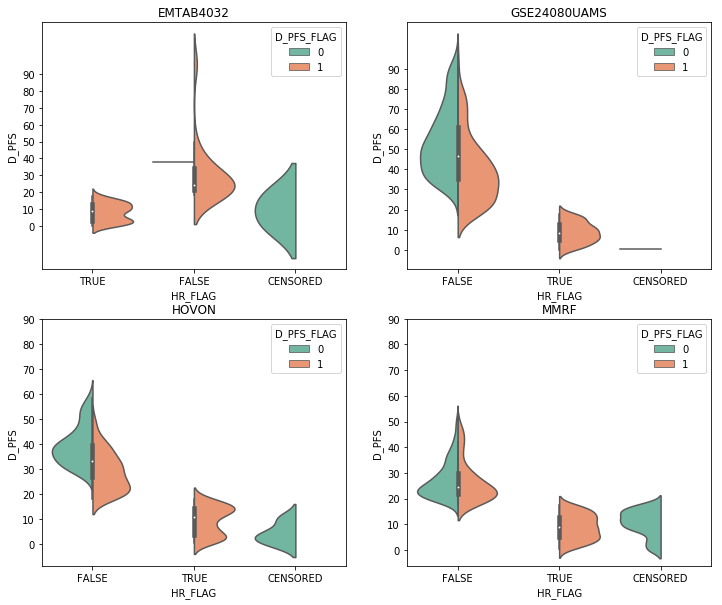

In [11]:
f,ax=plt.subplots(2,2,figsize=(12,10))
ax = ax.flatten()
sns.violinplot("HR_FLAG","D_PFS", hue="D_PFS_FLAG", data=globalClin_df[globalClin_df['Study']=='EMTAB4032'],split=True,ax=ax[0],palette="Set2")
ax[0].set_title('EMTAB4032')
ax[0].set_yticks(range(0,100,10))
sns.violinplot("HR_FLAG","D_PFS", hue="D_PFS_FLAG", data=globalClin_df[globalClin_df['Study']=='GSE24080UAMS'],split=True,ax=ax[1], palette="Set2")
ax[1].set_title('GSE24080UAMS')
ax[1].set_yticks(range(0,100,10))
sns.violinplot("HR_FLAG","D_PFS", hue="D_PFS_FLAG", data=globalClin_df[globalClin_df['Study']=='HOVON65'],split=True,ax=ax[2], palette="Set2")
ax[2].set_title('HOVON')
ax[2].set_yticks(range(0,100,10))
sns.violinplot("HR_FLAG","D_PFS", hue="D_PFS_FLAG", data=globalClin_df[globalClin_df['Study']=='MMRF'],split=True,ax=ax[3], palette="Set2")
ax[3].set_title('MMRF')
ax[3].set_yticks(range(0,100,10))
plt.show()


D_ISS: Multiple Myeloma International Staging Systems 

(Staging based on serum $ \beta $2 microglobulin and albumin levels)

| Stage|        Criteria                                                            |
|------|----------------------------------------------------------------------------|
|  I   | Serum $ \beta $2 microglobulin < 3.5 mg/L AND serum albumin $\geq$ 3.5g/dL |
|  II  | Serum $ \beta $2 microglobulin < 3.5 mg/L AND serum albumin $<   $ 3.5g/dL |
|  III | Serum $ \beta $2 microglobulin $\geq $ 5.5 mg/L                            |




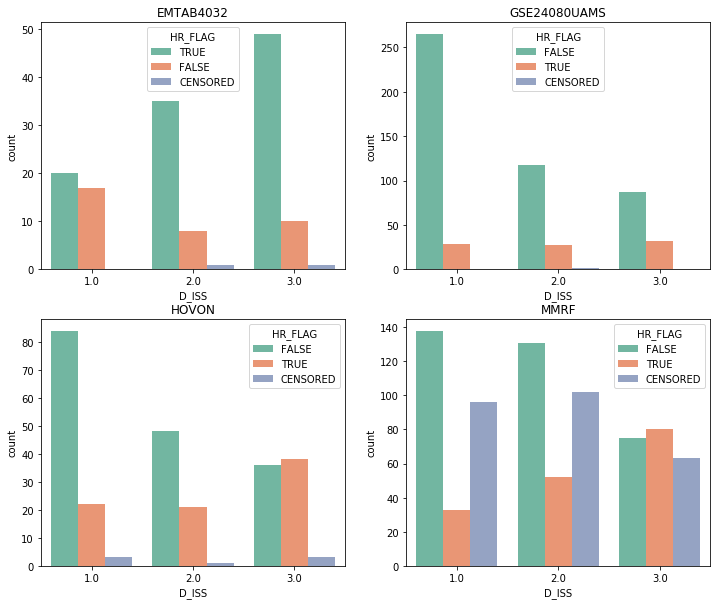

In [12]:
f,ax=plt.subplots(2,2,figsize=(12,10))
ax = ax.flatten()
sns.countplot("D_ISS",hue="HR_FLAG", data=globalClin_df[globalClin_df['Study']=='EMTAB4032'],ax=ax[0],palette="Set2")
ax[0].set_title('EMTAB4032')
sns.countplot("D_ISS",hue="HR_FLAG", data=globalClin_df[globalClin_df['Study']=='GSE24080UAMS'],ax=ax[1], palette="Set2")
ax[1].set_title('GSE24080UAMS')
sns.countplot("D_ISS",hue="HR_FLAG", data=globalClin_df[globalClin_df['Study']=='HOVON65'],ax=ax[2], palette="Set2")
ax[2].set_title('HOVON')
sns.countplot("D_ISS",hue="HR_FLAG", data=globalClin_df[globalClin_df['Study']=='MMRF'],ax=ax[3], palette="Set2")
ax[3].set_title('MMRF')
plt.show()

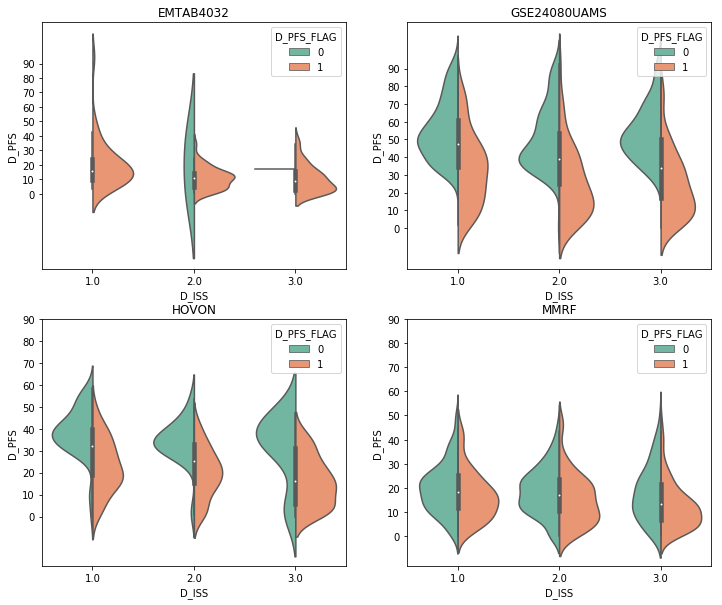

In [13]:
f,ax=plt.subplots(2,2,figsize=(12,10))
ax = ax.flatten()
sns.violinplot("D_ISS","D_PFS", hue="D_PFS_FLAG", data=globalClin_df[globalClin_df['Study']=='EMTAB4032'],split=True,ax=ax[0],palette="Set2")
ax[0].set_title('EMTAB4032')
ax[0].set_yticks(range(0,100,10))
sns.violinplot("D_ISS","D_PFS", hue="D_PFS_FLAG", data=globalClin_df[globalClin_df['Study']=='GSE24080UAMS'],split=True,ax=ax[1], palette="Set2")
ax[1].set_title('GSE24080UAMS')
ax[1].set_yticks(range(0,100,10))
sns.violinplot("D_ISS","D_PFS", hue="D_PFS_FLAG", data=globalClin_df[globalClin_df['Study']=='HOVON65'],split=True,ax=ax[2], palette="Set2")
ax[2].set_title('HOVON')
ax[2].set_yticks(range(0,100,10))
sns.violinplot("D_ISS","D_PFS", hue="D_PFS_FLAG", data=globalClin_df[globalClin_df['Study']=='MMRF'],split=True,ax=ax[3], palette="Set2")
ax[3].set_title('MMRF')
ax[3].set_yticks(range(0,100,10))
plt.show()


D_Age: Age at diagnosis

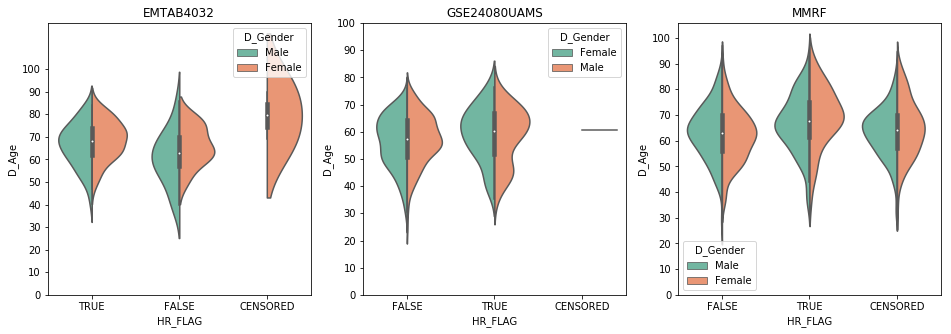

In [14]:
f,ax=plt.subplots(1,3,figsize=(16,5))
ax = ax.flatten()
sns.violinplot("HR_FLAG","D_Age", hue="D_Gender", data=globalClin_df[globalClin_df['Study']=='EMTAB4032'],split=True,ax=ax[0],palette='Set2')
ax[0].set_title('EMTAB4032')
ax[0].set_yticks(range(0,110,10))
sns.violinplot("HR_FLAG","D_Age", hue="D_Gender", data=globalClin_df[globalClin_df['Study']=='GSE24080UAMS'],split=True,ax=ax[1],palette='Set2')
ax[1].set_title('GSE24080UAMS')
ax[1].set_yticks(range(0,110,10))
# HOVON dataset missing 'D_Age'
#sns.violinplot("HR_FLAG","D_Age", hue="D_Gender", data=globalClin_df[globalClin_df['Study']=='HOVON65'],split=True,ax=ax[2])
#ax[2].set_title('D_Age and D_Gender vs HR_FLAG of HOVON dataset')
#ax[2].set_yticks(range(0,110,10))
sns.violinplot("HR_FLAG","D_Age", hue="D_Gender", data=globalClin_df[globalClin_df['Study']=='MMRF'],split=True,ax=ax[2],palette='Set2')
ax[2].set_title('MMRF')
ax[2].set_yticks(range(0,110,10))
plt.show()

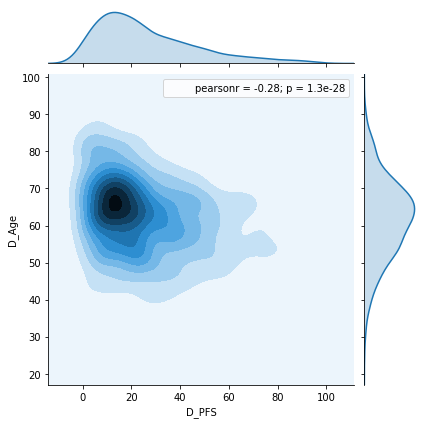

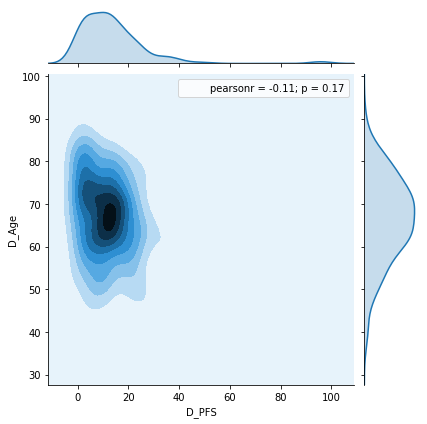

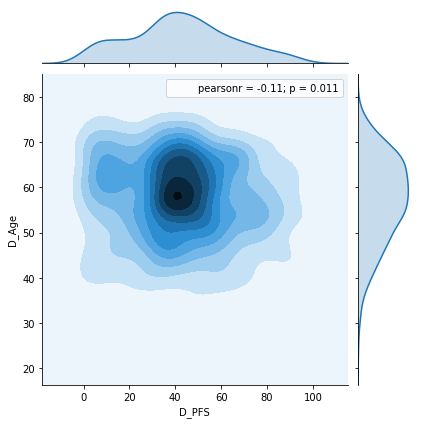

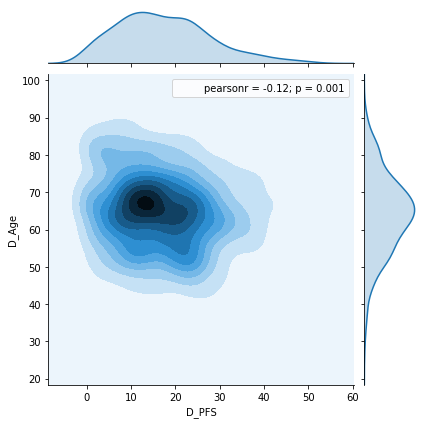

In [15]:
### D_Age & D_PFS
sns.jointplot("D_PFS","D_Age", data=globalClin_df,kind="kde")
sns.jointplot("D_PFS","D_Age", data=globalClin_df[globalClin_df['Study']=='EMTAB4032'],kind="kde")
sns.jointplot("D_PFS","D_Age",data=globalClin_df[globalClin_df['Study']=='GSE24080UAMS'],kind="kde")
sns.jointplot("D_PFS","D_Age", data=globalClin_df[globalClin_df['Study']=='MMRF'],kind="kde")

##### Gene Expression Data
Microarray datasets are all affymetrix chips and CEL files have been reprocessed (normalized) via the R oligo package with rma (rma robust multichip average) in order provide consistency. 

In [36]:
# loading microarray data
emtab_entrez_df=np.transpose(pd.read_csv('datasets/microarray/EMTAB4032entrezIDlevel.csv',index_col=0))
hovon_entrez_df=np.transpose(pd.read_csv('datasets/microarray/GSE19784HOVON65entrezIDlevel.csv',index_col=0))
uams_entrez_df=np.transpose(pd.read_csv('datasets/microarray/GSE24080UAMSentrezIDlevel.csv',index_col=0))
mmrf_entrez_df=np.transpose(pd.read_csv('datasets/microarray/GSE9782APEXentrezIDlevel_mas5.csv',index_col=0))

In [37]:
print(emtab_entrez_df.shape)
print(hovon_entrez_df.shape)
print(uams_entrez_df.shape)
print(mmrf_entrez_df.shape)

(147, 18994)
(282, 20514)
(559, 20514)
(264, 18081)


In [72]:
print('overlaped features # between EMTAB and HOVON:',pd.Series(np.intersect1d(pd.Series(emtab_entrez_df.columns.values),pd.Series(hovon_entrez_df.columns.values))).count())
print('overlaped features # between EMTAB and UAMS:',pd.Series(np.intersect1d(pd.Series(emtab_entrez_df.columns.values),pd.Series(uams_entrez_df.columns.values))).count())
print('overlaped features # between EMTAB and HOVON:',pd.Series(np.intersect1d(pd.Series(mmrf_entrez_df.columns.values),pd.Series(mmrf_entrez_df.columns.values))).count())
print('overlaped features # between UAMS and HOVON:',pd.Series(np.intersect1d(pd.Series(uams_entrez_df.columns.values),pd.Series(hovon_entrez_df.columns.values))).count())
print('overlaped features # between MMRF and HOVON:',pd.Series(np.intersect1d(pd.Series(mmrf_entrez_df.columns.values),pd.Series(hovon_entrez_df.columns.values))).count())
print('overlaped features # between UAMS and MMRF:',pd.Series(np.intersect1d(pd.Series(uams_entrez_df.columns.values),pd.Series(mmrf_entrez_df.columns.values))).count())
print('overlaped features # among EMTAB, HOVON and UAMS:',pd.Series(np.intersect1d(pd.Series(np.intersect1d(pd.Series(emtab_entrez_df.columns.values),pd.Series(hovon_entrez_df.columns.values))),pd.Series(uams_entrez_df.columns.values))).count())
print('overlaped features # among EMTAB, HOVON and MMRF:',pd.Series(np.intersect1d(pd.Series(np.intersect1d(pd.Series(emtab_entrez_df.columns.values),pd.Series(hovon_entrez_df.columns.values))),pd.Series(mmrf_entrez_df.columns.values))).count())
print('overlaped features # among EMTAB, MMRF and UAMS:',pd.Series(np.intersect1d(pd.Series(np.intersect1d(pd.Series(emtab_entrez_df.columns.values),pd.Series(mmrf_entrez_df.columns.values))),pd.Series(uams_entrez_df.columns.values))).count())
print('overlaped features # among MMRF, HOVON and UAMS:',pd.Series(np.intersect1d(pd.Series(np.intersect1d(pd.Series(mmrf_entrez_df.columns.values),pd.Series(hovon_entrez_df.columns.values))),pd.Series(uams_entrez_df.columns.values))).count())
print('overlaped features # among EMTAB, HOVON, MMRF and UAMS:',pd.Series(np.intersect1d(pd.Series(np.intersect1d(pd.Series(np.intersect1d(pd.Series(emtab_entrez_df.columns.values),pd.Series(hovon_entrez_df.columns.values))),pd.Series(uams_entrez_df.columns.values))),pd.Series(mmrf_entrez_df.columns.values))).count())

overlaped features # between EMTAB and HOVON: 17038
overlaped features # between EMTAB and UAMS: 17038
overlaped features # between EMTAB and HOVON: 18081
overlaped features # between UAMS and HOVON: 20514
overlaped features # between MMRF and HOVON: 18081
overlaped features # between UAMS and MMRF: 18081
overlaped features # among EMTAB, HOVON and UAMS: 17038
overlaped features # among EMTAB, HOVON and MMRF: 16017
overlaped features # among EMTAB, MMRF and UAMS: 16017
overlaped features # among MMRF, HOVON and UAMS: 18081
overlaped features # among EMTAB, HOVON, MMRF and UAMS: 16017
